In [1]:
%pip install numpy
%pip install pandas
%pip install networkx
%pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy
import pandas
import math

In [3]:
train_df = pandas.read_csv('train.csv')
test_df = pandas.read_csv('test.csv')

In [4]:
# train_df.head()
# test_df.head()

,pclass,age,gender,survived
0,1st,adult,male,yes
1,1st,adult,male,yes
2,1st,adult,male,yes
3,1st,adult,male,yes
4,1st,adult,male,yes


# Looking at the training data

In [6]:
train_df.describe()

,pclass,age,gender,survived
count,2150,2150,2150,2150
unique,4,2,2,2
top,crew,adult,male,no
freq,885,2046,1710,1485


In [7]:
for col in train_df.columns:
    value_counts = train_df[col].value_counts()

    # print (f'Column: {col}')
    print (value_counts, '\n')

pclass
crew    885
3rd     699
1st     307
2nd     259
Name: count, dtype: int64 

age
adult    2046
child     104
Name: count, dtype: int64 

gender
male      1710
female     440
Name: count, dtype: int64 

survived
no     1485
yes     665
Name: count, dtype: int64 



# Classifier Model : Decision Tree

In [8]:
class Node:
    def __init__(self, feature_index=None, feature_name=None, prediction=None, 
                is_leaf=False, children=None, target_values=None):
        self.feature_index = feature_index
        self.feature_name = feature_name
        self.prediction = prediction
        self.is_leaf = is_leaf
        self.children = children
        self.target_values = target_values

In [9]:
feature_indices = {
    "pclass" : 0, 
    "age" : 1, 
    "gender" : 2
}

feature_names = {
    0 : "pclass", 
    1 : "age", 
    2 : "gender"
}

In [10]:
def calculate_entropy (column_values: numpy.ndarray):
    _, value_counts = numpy.unique (column_values, return_counts=True)
    probabilities = value_counts / len(column_values)

    entropy = 0
    for prob in probabilities:
        entropy += -(prob * math.log(prob))

    return entropy

In [11]:
def calculate_information_gain (data: pandas.core.frame.DataFrame, feature_name: str, target_feature: str):
    # print (data[target_feature].values)
    initial_entropy = calculate_entropy(data[target_feature].values)

    unique_values = data[feature_name].unique()
    weighted_entropy = 0

    for value in unique_values:
        data_subset = data[data[feature_name] == value]
        subset_entropy = calculate_entropy(data_subset[target_feature].values)

        weighted_entropy += (len(data_subset) / len(data)) * subset_entropy

    information_gain = initial_entropy - weighted_entropy
    return information_gain

In [12]:
def find_best_split (data: pandas.core.frame.DataFrame, target_feature: str):
    best_information_gain = float('-inf')
    best_feature = None

    for feature in data.columns:
        if (feature == target_feature):
            continue
        # print (feature)
        info_gain = calculate_information_gain(data, feature, target_feature)
        if (info_gain > best_information_gain):
            best_information_gain = info_gain
            best_feature = feature

    return best_information_gain, best_feature

In [13]:
def build_tree (data: pandas.core.frame.DataFrame, target_feature: str):
    # print ("Value Counts: ")
    # for col in data.columns:
    #     print (data[col].value_counts())
    # print("Current Entropy: ", calculate_entropy(data[target_feature].values))

    if (calculate_entropy(data[target_feature].values) == 0 or data.shape[1] == 1):
        # print (data[target_feature])
        leaf = Node(prediction=data[target_feature].mode(), is_leaf=True)
        return leaf

    info_gain, split_feature = find_best_split(data, target_feature)
    # print ("Splitting on: ", info_gain, " ", split_feature)
    # print ("\n")

    children = {}
    for value in data[split_feature].unique():
        # print (value)
        child_node = build_tree(data[data[split_feature] == value].drop(split_feature, axis=1), target_feature)
        children[value] = child_node
        # print (children)

    node = Node(feature_index=feature_indices[split_feature], feature_name=split_feature, children=children, target_values=data[target_feature].value_counts().to_dict())
    # print ("Added Children: ", children.keys())
    return node

In [14]:
def train_model (data: pandas.core.frame.DataFrame, target_feature: str):
    root = build_tree(data, target_feature)
    return root

In [15]:
def predict_example (root, test_example: numpy.ndarray):
    # print ("Test Example: ", test_example)
    node = root
    while (not node.is_leaf):
        feature_index = node.feature_index
        # print (feature_index)
        node = node.children[test_example[feature_index]]

    return node.prediction

In [16]:
def predict_model (root, test_data):
    predictions = []
    for index, row in test_data.iterrows():
        prediction = predict_example(root, row.values)
        predictions.append(prediction)
    return numpy.array(predictions).reshape(1, -1)

In [17]:
# classifier = DecisionTree()
classifier = train_model(train_df, 'survived')

In [18]:
# test_df = test_df.drop('survived', axis=1)
predictions = predict_model(classifier, test_df)
print (predictions, type(predictions))

[['no' 'no' 'no' 'no' 'no' 'no' 'no' 'no' 'no' 'no' 'no' 'no' 'no' 'no'
  'no' 'yes' 'yes' 'yes' 'yes' 'yes' 'yes' 'yes' 'yes' 'yes' 'yes' 'yes'
  'yes' 'yes' 'yes' 'yes' 'yes' 'yes' 'yes' 'no' 'no' 'no' 'no' 'no' 'no'
  'no' 'no' 'no' 'no' 'no' 'no' 'no' 'no' 'yes' 'yes' 'yes' 'yes' 'yes'
  'yes' 'yes' 'yes' 'yes' 'yes' 'yes' 'yes' 'no' 'no' 'no' 'no' 'no' 'no'
  'no']] <class 'numpy.ndarray'>


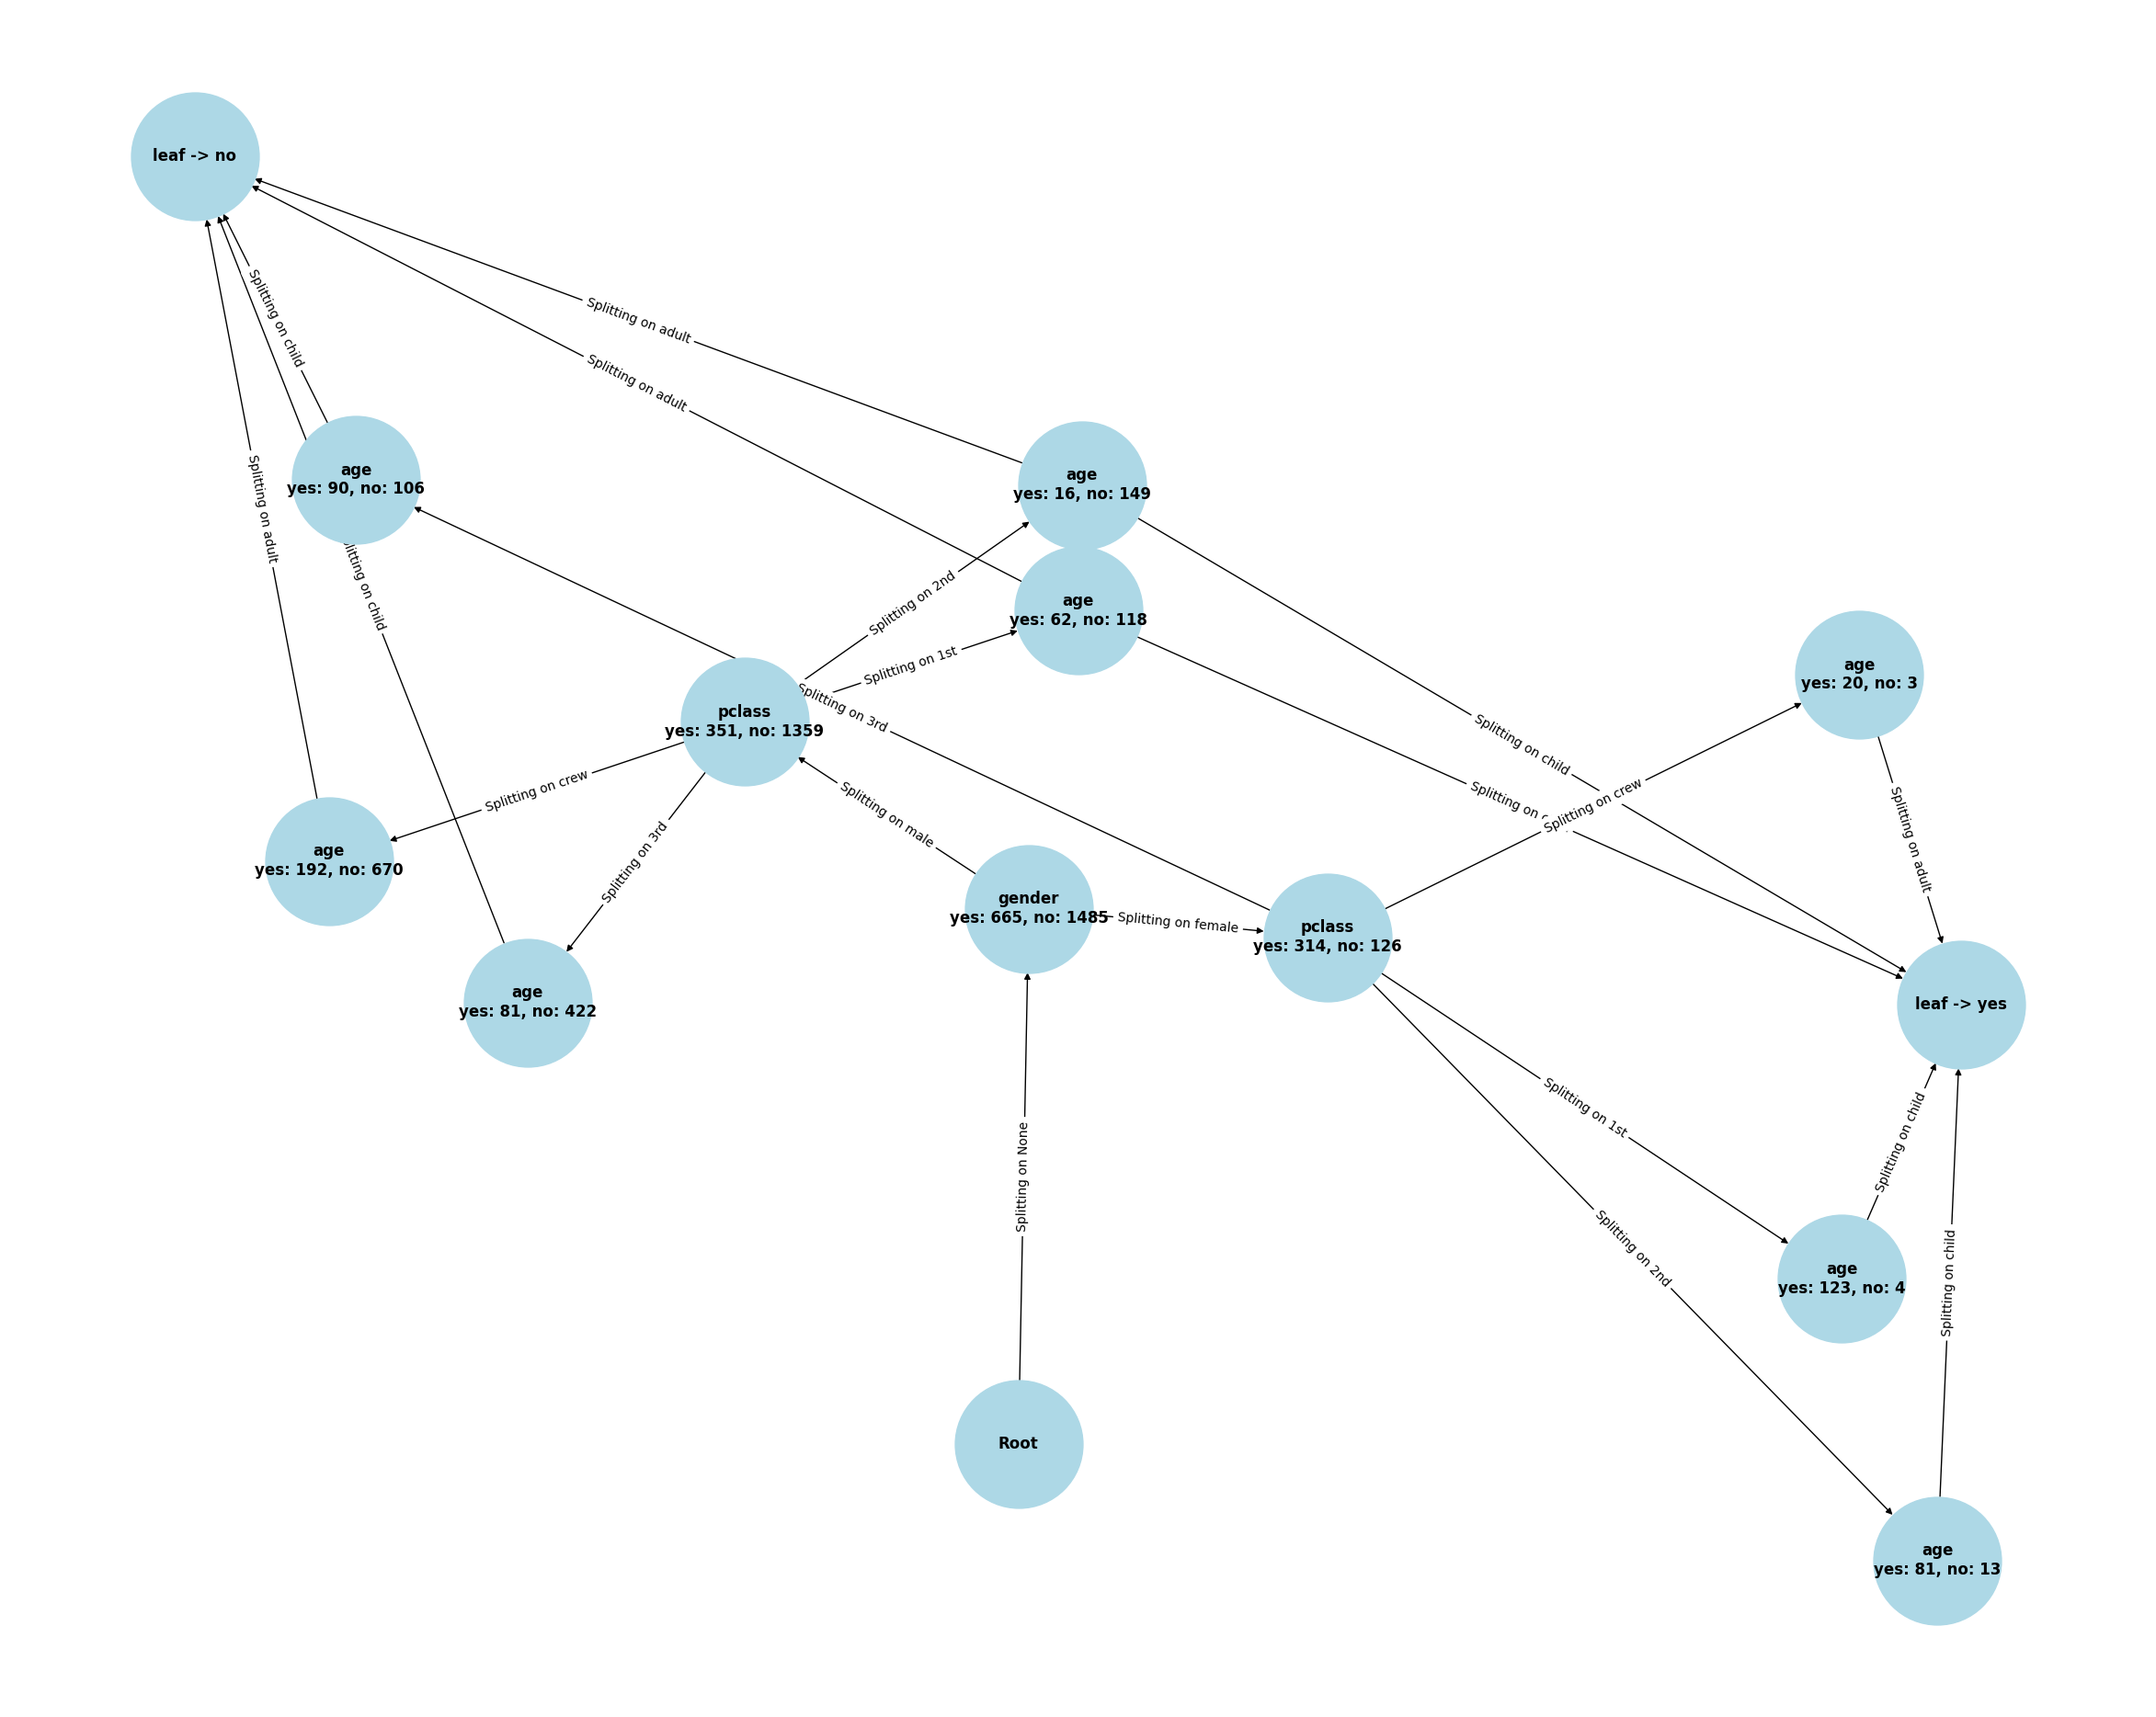

In [19]:
import matplotlib.pyplot as plt
import networkx as nx

fig, ax = plt.subplots(figsize=(30, 24))

# Create a directed graph
G = nx.DiGraph()

# Define a recursive function to add nodes and edges to the graph
def add_nodes_and_edges(tree: Node, parent=None, feature_value=None):
    feature_index = tree.feature_index
    is_leaf = tree.is_leaf

    if parent is not None:
        if feature_index is None:
            G.add_edge(parent.feature_name + f"\nyes: {parent.target_values['yes']}, no: {parent.target_values['no']}", 
                        f"leaf -> {tree.prediction[0]}", 
                        label=f"Splitting on {feature_value}")
        else:
            G.add_edge(parent.feature_name + f"\nyes: {parent.target_values['yes']}, no: {parent.target_values['no']}", 
                        tree.feature_name + f"\nyes: {tree.target_values['yes']}, no: {tree.target_values['no']}", 
                        label=f"Splitting on {feature_value}")

    if not is_leaf:
        for feature_value, child_tree in tree.children.items():
            add_nodes_and_edges(child_tree, tree, feature_value)

# Add nodes and edges to the graph
add_nodes_and_edges(classifier)
G.add_edge ("Root", f"{classifier.feature_name}\nyes: {classifier.target_values['yes']}, no: {classifier.target_values['no']}", label=f"Splitting on None")

# Plot the decision tree
# pos = nx.spring_layout(G, k=10.0)
pos = nx.fruchterman_reingold_layout(G, seed=42)

# pos = nx.nx_agraph.pygraphviz_layout(G, prog='dot')
nx.draw(G, pos, with_labels=True, node_size=10000, node_color='lightblue', font_size=12, font_weight='bold')

edge_labels = {edge: G.edges[edge]['label'] for edge in G.edges}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

plt.show()


In [ ]:
# ['no' 'no' 'no' 'no' 'no' 'no' 'no' 'no' 'no' 'no' 'no' 'no' 'no' 'no' 'no' 'yes' 'yes' 'yes' 'yes' 'yes' 'yes' 'yes' 'yes' 'yes' 'yes' 'yes' 'yes' 'yes' 'yes' 'yes' 'yes' 'yes' 'yes' 'no' 'no' 'no' 'no' 'no' 'no' 'no' 'no' 'no' 'no' 'no' 'no' 'no' 'no' 'yes' 'yes' 'yes' 'yes' 'yes' 'yes' 'yes' 'yes' 'yes' 'yes' 'yes' 'yes' 'no' 'no' 'no' 'no' 'no' 'no''no']
# ['no' 'no' 'no' 'no' 'no' 'no' 'no' 'no' 'no' 'no' 'no' 'no' 'no' 'no' 'no' 'yes' 'yes' 'yes' 'yes' 'yes' 'yes' 'yes' 'yes' 'yes' 'yes' 'yes' 'yes' 'yes' 'yes' 'yes' 'yes' 'yes' 'yes' 'no' 'no' 'no' 'no' 'no' 'no' 'no' 'no' 'no' 'no' 'no' 'no' 'no' 'no' 'yes' 'yes' 'yes' 'yes' 'yes' 'yes' 'yes' 'yes' 'yes' 'yes' 'yes' 'yes' 'no' 'no' 'no' 'no' 'no' 'no' 'no']